In [6]:
import os
import pandas as pd
import numpy as np
import glob
from typing import List, Dict, Any, Union

def parse_fixed_width(line, field_defs):
    """Parse a fixed-width line according to field definitions"""
    result = {}
    
    for field in field_defs:
        # Convert from 1-indexed (README) to 0-indexed (Python)
        start = field['start'] - 1
        end = field['end']
        
        # Handle out-of-bounds and extract value
        if start >= len(line):
            value = field.get('default', None)
        else:
            end = min(end, len(line))
            field_str = line[start:end].strip()
            
            # Convert to appropriate type
            if field_str == '' or field_str == '---':
                value = field.get('default', None)
            else:
                try:
                    if field['type'] == int:
                        value = int(field_str)
                    elif field['type'] == float:
                        value = float(field_str)
                    else:
                        value = field_str
                except (ValueError, TypeError):
                    value = field.get('default', None)
        
        result[field['name']] = value
    
    return result

def parse_hipparcos_file(filepath):
    """Parse a single Hipparcos file (.d) and return its data"""
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    if len(lines) < 14:  # Need header + at least 1 data record
        print(f"File {filepath} appears incomplete")
        return []
    
    # Define field definitions according to README
    header1_fields = [
        {'name': 'HIP', 'start': 3, 'end': 9, 'type': int, 'default': -1},
        {'name': 'MCE', 'start': 10, 'end': 16, 'type': int, 'default': -1},
        {'name': 'NRES', 'start': 17, 'end': 20, 'type': int, 'default': 0},
        {'name': 'NC', 'start': 22, 'end': 23, 'type': int, 'default': -1},
        {'name': 'isol_n', 'start': 25, 'end': 28, 'type': int, 'default': -1},
        {'name': 'SCE', 'start': 32, 'end': 36, 'type': int, 'default': -1},
        {'name': 'F2', 'start': 37, 'end': 43, 'type': float, 'default': np.nan},
        {'name': 'F1', 'start': 44, 'end': 46, 'type': int, 'default': -1}
    ]
    
    header2_fields = [
        {'name': 'Hp', 'start': 3, 'end': 10, 'type': float, 'default': np.nan},
        {'name': 'B-V', 'start': 11, 'end': 17, 'type': float, 'default': np.nan},
        {'name': 'VarAnn', 'start': 18, 'end': 19, 'type': int, 'default': -1},
        {'name': 'NOB', 'start': 25, 'end': 28, 'type': int, 'default': -1},
        {'name': 'NR', 'start': 29, 'end': 32, 'type': int, 'default': -1}
    ]
    
    # Main astrometric parameters
    header3_fields = [
        {'name': 'RAdeg', 'start': 3, 'end': 15, 'type': float, 'default': np.nan},
        {'name': 'DEdeg', 'start': 16, 'end': 28, 'type': float, 'default': np.nan},
        {'name': 'Plx', 'start': 29, 'end': 37, 'type': float, 'default': np.nan},
        {'name': 'pmRA', 'start': 38, 'end': 46, 'type': float, 'default': np.nan},
        {'name': 'pmDE', 'start': 47, 'end': 55, 'type': float, 'default': np.nan},
        {'name': 'e_RA', 'start': 56, 'end': 62, 'type': float, 'default': np.nan},
        {'name': 'e_DE', 'start': 63, 'end': 69, 'type': float, 'default': np.nan},
        {'name': 'e_Plx', 'start': 70, 'end': 76, 'type': float, 'default': np.nan},
        {'name': 'e_pmRA', 'start': 77, 'end': 83, 'type': float, 'default': np.nan},
        {'name': 'e_pmDE', 'start': 84, 'end': 90, 'type': float, 'default': np.nan}
    ]
    
    data_fields = [
        {'name': 'IORB', 'start': 3, 'end': 7, 'type': int, 'default': -1},
        {'name': 'EPOCH', 'start': 8, 'end': 15, 'type': float, 'default': np.nan},
        {'name': 'PARF', 'start': 16, 'end': 23, 'type': float, 'default': np.nan},
        {'name': 'CPSI', 'start': 24, 'end': 31, 'type': float, 'default': np.nan},
        {'name': 'SPSI', 'start': 32, 'end': 39, 'type': float, 'default': np.nan},
        {'name': 'RES', 'start': 40, 'end': 47, 'type': float, 'default': np.nan},
        {'name': 'SRES', 'start': 48, 'end': 54, 'type': float, 'default': np.nan}
    ]
    
    # Parse header lines
    header1 = parse_fixed_width(lines[6], header1_fields)
    header2 = parse_fixed_width(lines[8], header2_fields)
    header3 = parse_fixed_width(lines[10], header3_fields)
    
    # Parse data records
    data_list = []
    for i in range(13, len(lines)):
        if lines[i].strip():  # Skip empty lines
            data_record = parse_fixed_width(lines[i], data_fields)
            
            # Combine header info with data record
            combined_record = {**header1, **header2, **header3, **data_record}
            
            # Add derived fields
            combined_record['Rejected'] = combined_record['SRES'] <= 0
            combined_record['FileName'] = os.path.basename(filepath)
            
            data_list.append(combined_record)
    
    return data_list

def create_hipparcos_csv_all_folders(base_dir, output_file='hipparcos_all_data.csv'):
    """
    Process Hipparcos .d files from folders H000 to H120 and create a CSV for modeling
    
    Parameters:
    -----------
    base_dir : str
        Base directory containing the H000-H120 folders
    output_file : str
        Name of the output CSV file
        
    Returns:
    --------
    pandas.DataFrame
        The combined dataset
    """
    all_data = []
    total_files_processed = 0
    total_records = 0
    
    # Process each folder from H000 to H120
    for folder_num in range(0, 121):
        folder_name = f"H{folder_num:03d}"
        folder_path = os.path.join(base_dir, folder_name)
        
        if not os.path.exists(folder_path):
            print(f"Warning: Folder {folder_path} does not exist, skipping...")
            continue
            
        print(f"Processing folder {folder_name}...")
        files_processed = 0
        
        # Find all .d files in the current folder
        for d_file in glob.glob(os.path.join(folder_path, "*.d")):
            try:
                file_data = parse_hipparcos_file(d_file)
                if file_data:
                    all_data.extend(file_data)
                    total_records += len(file_data)
                    files_processed += 1
                    total_files_processed += 1
                    
                    # Progress updates
                    if files_processed % 500 == 0:
                        print(f"  Processed {files_processed} files in {folder_name}...")
            except Exception as e:
                print(f"Error processing {d_file}: {e}")
        
        print(f"Completed folder {folder_name}: {files_processed} files, {total_records} total records so far")
    
    # Create DataFrame and save to CSV
    if all_data:
        df = pd.DataFrame(all_data)
        df.to_csv(output_file, index=False)
        print(f"Created {output_file} with {len(df)} records from {total_files_processed} files across all folders")
        return df
    else:
        print("No data extracted")
        return None




In [7]:

df = create_hipparcos_csv_all_folders("./ResRec_JavaTool_2014/", "hipparcos_complete_data.csv")

Processing folder H000...
  Processed 500 files in H000...
Completed folder H000: 997 files, 134378 total records so far
Processing folder H001...
  Processed 500 files in H001...
Completed folder H001: 997 files, 261166 total records so far
Processing folder H002...
  Processed 500 files in H002...
Completed folder H002: 999 files, 378129 total records so far
Processing folder H003...
  Processed 500 files in H003...
Completed folder H003: 996 files, 494346 total records so far
Processing folder H004...
  Processed 500 files in H004...
  Processed 1000 files in H004...
Completed folder H004: 1000 files, 615943 total records so far
Processing folder H005...
  Processed 500 files in H005...
Completed folder H005: 997 files, 734707 total records so far
Processing folder H006...
  Processed 500 files in H006...
Completed folder H006: 999 files, 855430 total records so far
Processing folder H007...
  Processed 500 files in H007...
Completed folder H007: 999 files, 970872 total records so f

In [11]:
df.shape

(13678821, 32)

In [1]:
import pandas as pd
import numpy as np
import os

def create_subset_csv(input_csv, output_csv, num_stars=100, random_seed=42):
    """
    Create a smaller CSV file with data from a limited number of stars.
    
    Parameters:
    -----------
    input_csv : str
        Path to the full Hipparcos dataset CSV
    output_csv : str
        Path to save the smaller subset CSV
    num_stars : int
        Number of unique stars (HIP IDs) to include
    random_seed : int
        Random seed for reproducibility when selecting stars
    """
    print(f"Reading Hipparcos data from {input_csv}...")
    
    # Instead of loading the entire file at once, use chunks to find unique HIP IDs
    unique_hips = set()
    for chunk in pd.read_csv(input_csv, chunksize=500000):
        unique_hips.update(chunk['HIP'].unique())
    
    # Convert to list and select a random sample of stars
    all_unique_hips = list(unique_hips)
    print(f"Found {len(all_unique_hips)} unique stars in the dataset")
    
    np.random.seed(random_seed)
    selected_hips = np.random.choice(all_unique_hips, size=min(num_stars, len(all_unique_hips)), replace=False)
    print(f"Selected {len(selected_hips)} stars for the subset")
    
    # Process the file in chunks to extract only data for selected stars
    subset_data = []
    for chunk in pd.read_csv(input_csv, chunksize=500000):
        subset_chunk = chunk[chunk['HIP'].isin(selected_hips)]
        if not subset_chunk.empty:
            subset_data.append(subset_chunk)
    
    # Combine all chunks and save to CSV
    if subset_data:
        subset_df = pd.concat(subset_data, ignore_index=True)
        subset_df.to_csv(output_csv, index=False)
        print(f"Created subset CSV at {output_csv}")
        print(f"Subset size: {os.path.getsize(output_csv) / (1024*1024):.2f} MB")
        print(f"Number of measurements in subset: {len(subset_df)}")
        return subset_df
    else:
        print("No data was found for the selected stars")
        return None




In [2]:

subset_df = create_subset_csv("hipparcos_complete_data.csv", "hipparcos_subset_100stars.csv", num_stars=100)

Reading Hipparcos data from hipparcos_complete_data.csv...
Found 117950 unique stars in the dataset
Selected 100 stars for the subset
Created subset CSV at hipparcos_subset_100stars.csv
Subset size: 2.04 MB
Number of measurements in subset: 12089


### Analysis on smaller data

Average measurements per star: 120.9
Range: 51 to 291 measurements


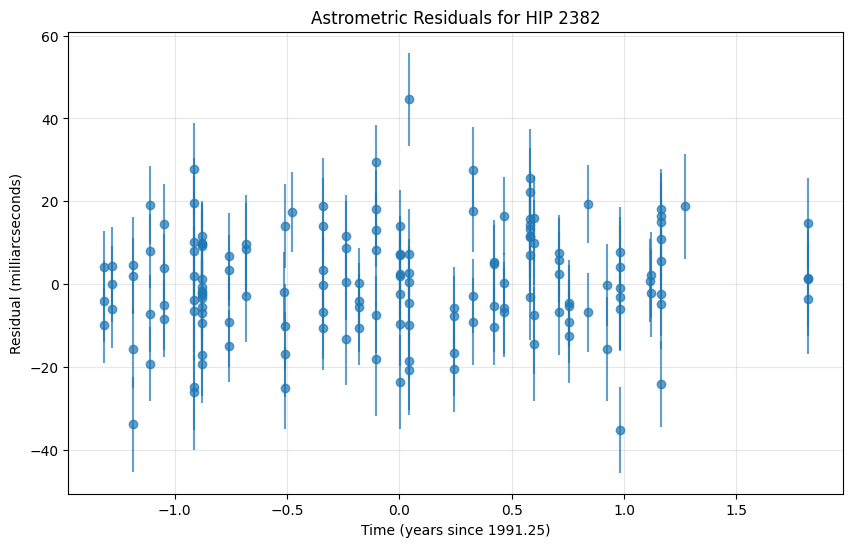

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the subset
df = pd.read_csv("hipparcos_subset_100stars.csv")

# Count measurements per star
measurements_per_star = df.groupby('HIP').size()
print(f"Average measurements per star: {measurements_per_star.mean():.1f}")
print(f"Range: {measurements_per_star.min()} to {measurements_per_star.max()} measurements")

# Plot residuals for a single star to visualize potential "wobble"
example_hip = df['HIP'].unique()[0]  # Choose first star
star_data = df[df['HIP'] == example_hip]

plt.figure(figsize=(10, 6))
# Only use valid measurements (SRES > 0)
valid_measurements = star_data[star_data['SRES'] > 0]
plt.errorbar(valid_measurements['EPOCH'], valid_measurements['RES'], 
             yerr=valid_measurements['SRES'], fmt='o', alpha=0.7)
plt.title(f'Astrometric Residuals for HIP {example_hip}')
plt.xlabel('Time (years since 1991.25)')
plt.ylabel('Residual (milliarcseconds)')
plt.grid(True, alpha=0.3)
plt.savefig(f'HIP_{example_hip}_residuals.png')
plt.show()


In [4]:
def create_features_for_modeling(df):
    """Create star-level features from time-series measurements"""
    
    features = []
    
    for hip, star_data in df.groupby('HIP'):
        # Use only valid measurements
        valid_data = star_data[star_data['SRES'] > 0]
        
        if len(valid_data) < 10:  # Skip stars with too few measurements
            continue
            
        # Star parameters (constant for each star)
        plx = valid_data['Plx'].iloc[0]
        pmRA = valid_data['pmRA'].iloc[0]
        pmDE = valid_data['pmDE'].iloc[0]
        
        # Time series features
        res_mean = valid_data['RES'].mean()
        res_std = valid_data['RES'].std()
        res_min = valid_data['RES'].min()
        res_max = valid_data['RES'].max()
        res_range = res_max - res_min
        
        # Count measurements
        n_measurements = len(valid_data)
        
        feature_dict = {
            'HIP': hip,
            'Plx': plx,
            'pmRA': pmRA, 
            'pmDE': pmDE,
            'res_mean': res_mean,
            'res_std': res_std,
            'res_range': res_range,
            'n_measurements': n_measurements
        }
        
        features.append(feature_dict)
    
    return pd.DataFrame(features)

# Create features dataframe
features_df = create_features_for_modeling(df)
features_df.to_csv("hipparcos_star_features.csv", index=False)


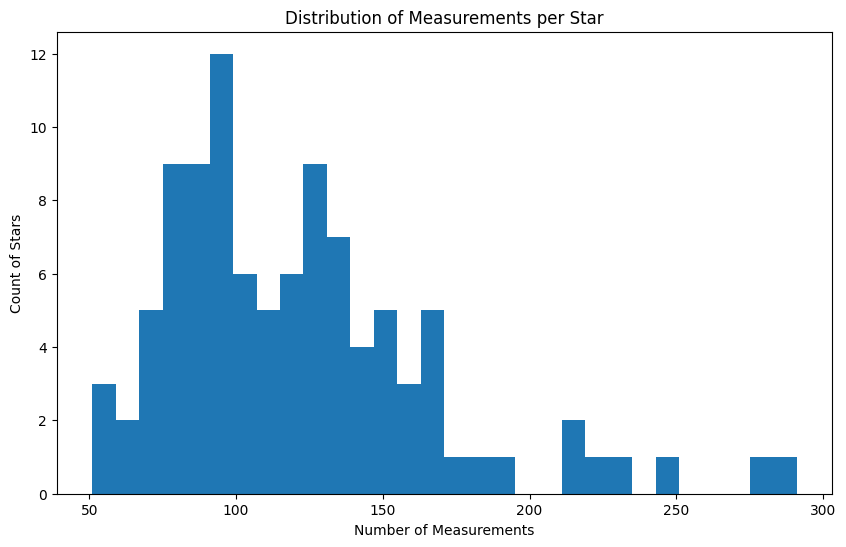

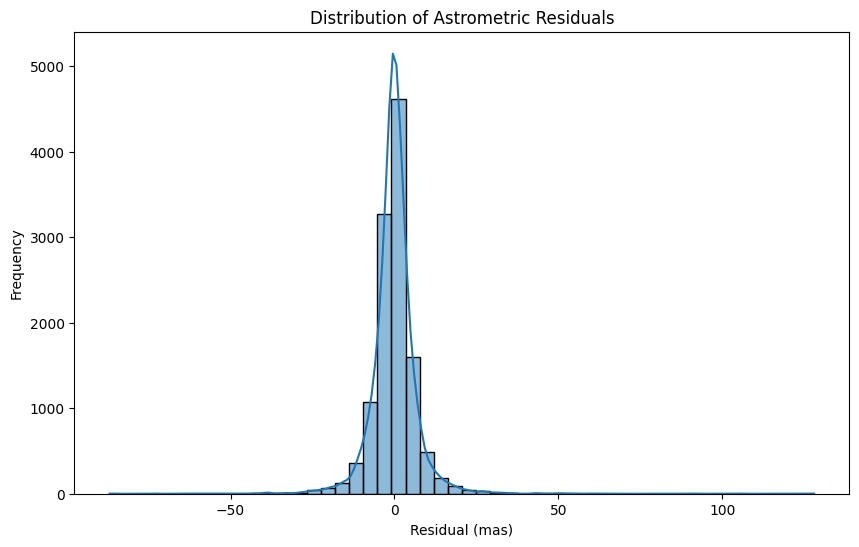

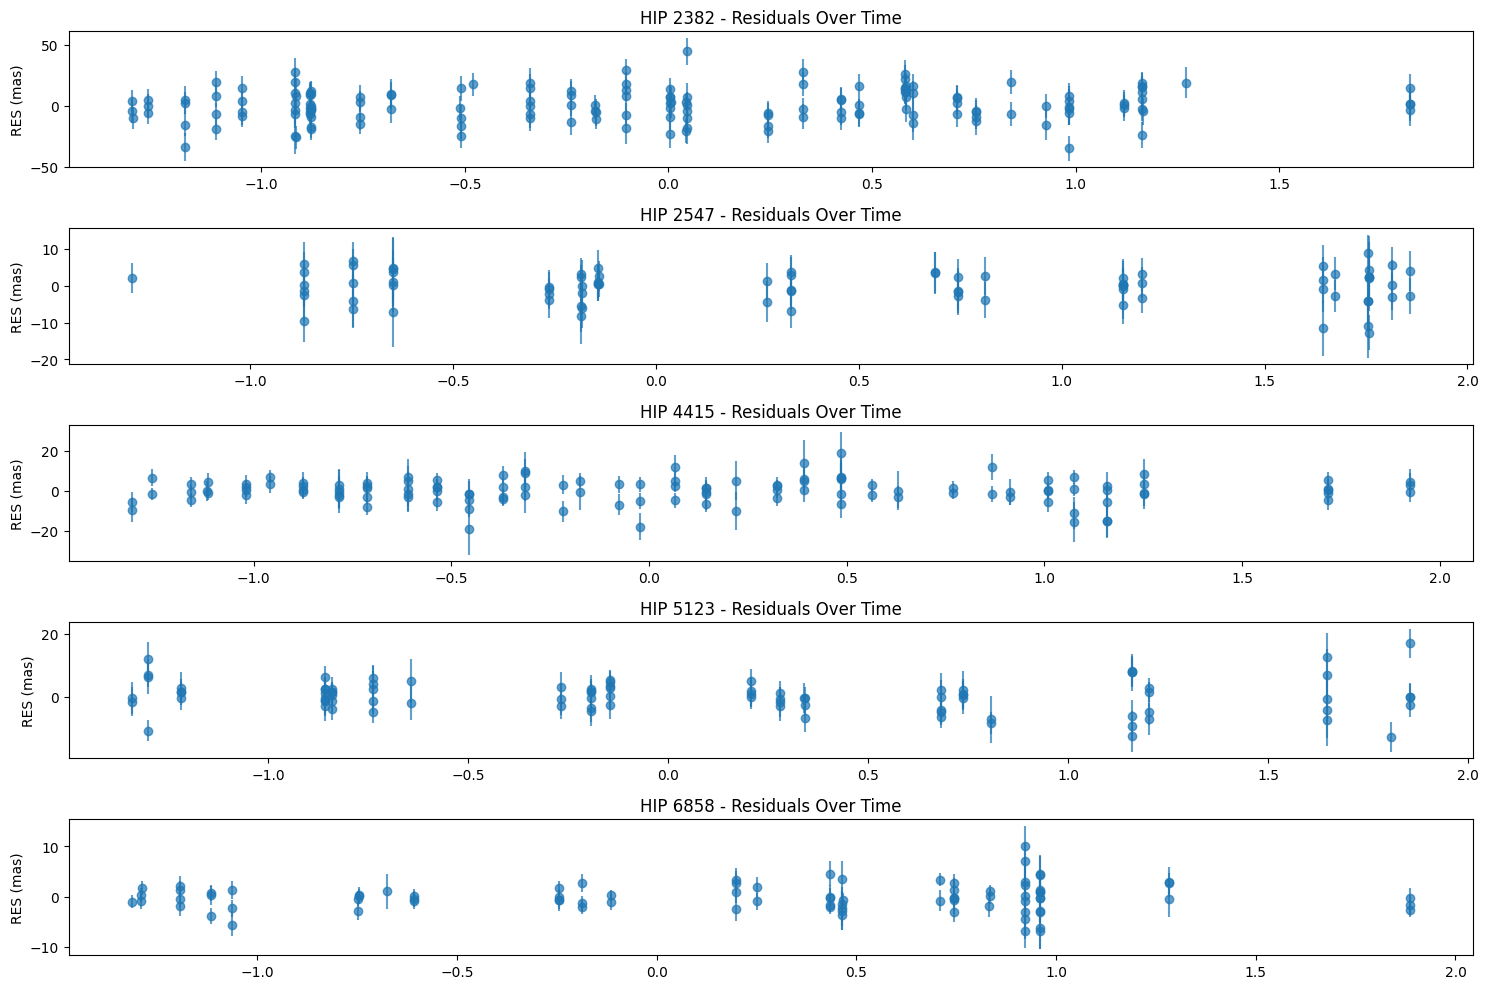

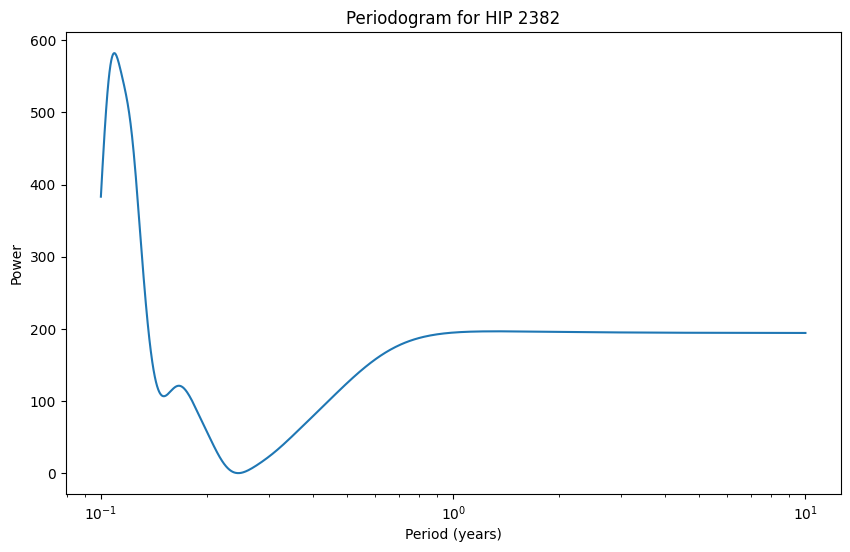

In [7]:
# For the histogram of measurements per star
plt.figure(figsize=(10, 6))
plt.hist(star_counts, bins=30)
plt.title('Distribution of Measurements per Star')
plt.xlabel('Number of Measurements')
plt.ylabel('Count of Stars')
plt.show()  # Just display, don't save

# For the residual distribution
plt.figure(figsize=(10, 6))
df_valid = df[df['SRES'] > 0]  # Only valid measurements
sns.histplot(df_valid['RES'], bins=50, kde=True)
plt.title('Distribution of Astrometric Residuals')
plt.xlabel('Residual (mas)')
plt.ylabel('Frequency')
plt.show()  # Just display, don't save

# For the time series analysis of example stars
plt.figure(figsize=(15, 10))

for i, hip in enumerate(example_stars):
    star_data = df[(df['HIP'] == hip) & (df['SRES'] > 0)]
    if len(star_data) < 10:
        continue
        
    plt.subplot(len(example_stars), 1, i+1)
    plt.errorbar(star_data['EPOCH'], star_data['RES'], 
                 yerr=star_data['SRES'], fmt='o', alpha=0.7)
    plt.title(f'HIP {hip} - Residuals Over Time')
    plt.ylabel('RES (mas)')
    
plt.tight_layout()
plt.show()  # Just display, don't save

# For the periodogram plot
example_hip = example_stars[0]
star_data = df[(df['HIP'] == example_hip) & (df['SRES'] > 0)]

periods, power, frequencies = compute_periodogram(star_data)
if periods is not None:
    plt.figure(figsize=(10, 6))
    plt.plot(periods, power)
    plt.title(f'Periodogram for HIP {example_hip}')
    plt.xlabel('Period (years)')
    plt.ylabel('Power')
    plt.xscale('log')
    plt.show()  # Just display, don't save
